LSTM for Time Series Forecasting with of Pond Water Conditions

In [1]:
# Import libraries
# !pip3 install keras
import pandas as pd
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

2023-02-25 17:06:03.112632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import Data
df = pd.read_csv('cleaned_Pond2.csv', delimiter = ',', index_col = 0)

In [3]:
# Set Datetime as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [4]:
# Resample to 1 minute
df_resampled = df.resample('5min').mean()

# Print resampled data missing values count and percentage
print("Before Fill")
print("Missing Values Count: ", df_resampled.isnull().sum())
print("Missing Values Percentage: ", df_resampled.isnull().sum()/len(df_resampled))


Before Fill
Missing Values Count:  Temperature         16900
Turbidity           16900
Dissolved Oxygen    16900
PH                  16900
Ammonia             16900
Nitrate             16900
Population          16900
Fish_Length         16900
Fish_Weight         16900
Weight_diff         16900
dtype: int64
Missing Values Percentage:  Temperature         0.437915
Turbidity           0.437915
Dissolved Oxygen    0.437915
PH                  0.437915
Ammonia             0.437915
Nitrate             0.437915
Population          0.437915
Fish_Length         0.437915
Fish_Weight         0.437915
Weight_diff         0.437915
dtype: float64


In [5]:
#  Fill missing value qirg backfill
df_resampled.fillna(method='bfill', inplace=True)
print("After Fill")
print("Missing Values Count: ", df_resampled.isnull().sum())
print("Missing Values Percentage: ", df_resampled.isnull().sum()/len(df_resampled))

# save to csv
# df_resampled.to_csv('resampled_Pond2.csv')

After Fill
Missing Values Count:  Temperature         0
Turbidity           0
Dissolved Oxygen    0
PH                  0
Ammonia             0
Nitrate             0
Population          0
Fish_Length         0
Fish_Weight         0
Weight_diff         0
dtype: int64
Missing Values Percentage:  Temperature         0.0
Turbidity           0.0
Dissolved Oxygen    0.0
PH                  0.0
Ammonia             0.0
Nitrate             0.0
Population          0.0
Fish_Length         0.0
Fish_Weight         0.0
Weight_diff         0.0
dtype: float64


In [6]:
# display the first 5 rows of the data
df.head()

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Population,Fish_Length,Fish_Weight,Date,Time,Weight_diff
Datetime,,,,,,,,,,,,
2021-06-19 00:00:05,24.8750,100,4.505,8.43365,0.38,193,50,6.96,3.36,2021-06-19,00:00:05,0.7
2021-06-19 00:01:02,24.9375,100,6.601,8.43818,0.38,194,50,6.96,3.36,2021-06-19,00:01:02,0.0
2021-06-19 00:01:22,24.8750,100,15.797,8.42457,0.38,192,50,6.96,3.36,2021-06-19,00:01:22,0.0
2021-06-19 00:01:44,24.9375,100,5.046,8.43365,0.38,193,50,6.96,3.36,2021-06-19,00:01:44,0.0
2021-06-19 00:02:07,24.9375,100,38.407,8.40641,0.38,192,50,6.96,3.36,2021-06-19,00:02:07,0.0


In [7]:
#  Display the first 5 rows
df_resampled.head()

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Population,Fish_Length,Fish_Weight,Weight_diff
Datetime,,,,,,,,,,
2021-06-19 00:00:00,24.909091,100.0,9.904182,8.433647,0.38,192.636364,50.0,6.96,3.36,0.063636
2021-06-19 00:05:00,24.888393,100.0,16.753714,8.431054,0.38,191.571429,50.0,6.96,3.36,0.000000
2021-06-19 00:10:00,24.886364,100.0,9.290000,8.432408,0.38,188.636364,50.0,6.96,3.36,0.000000
2021-06-19 00:15:00,24.875000,100.0,9.658556,8.434152,0.38,190.555556,50.0,6.96,3.36,0.000000
2021-06-19 00:20:00,24.848958,100.0,12.080667,8.427975,0.38,188.833333,50.0,6.96,3.36,0.000000


In [8]:
# Display Datetime range
print(df_resampled.index.min())
print(df_resampled.index.max())

2021-06-19 00:00:00
2021-10-30 23:55:00


In [9]:
# Create Training and Test Sets
split_point = round(len(df_resampled) * 0.8)
train_df = df_resampled.iloc[:split_point]
test_df = df_resampled.iloc[split_point:]

In [10]:
# Reset Index for train and test sets
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [12]:
#  Create Sequence Data for LSTM
seq_arrays = []
seq_labels = []

seq_length = 25 # switch to longer sequence length?
ph = 5 # switch prediction horizon?
feat_cols = ["Temperature"]

# List of sequences and labels
for start in range(0,len(train_df)-seq_length-ph):
  seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
  seq_labels.append(train_df['Temperature'].iloc[start+seq_length+ph])
    
#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labels = np.array(seq_labels, dtype=object).astype(np.float32)

    

In [13]:
assert(seq_arrays.shape == (len(train_df) - seq_length - ph, seq_length, len(feat_cols)))
assert(seq_labels.shape == (len(train_df) - seq_length - ph, ))

In [14]:
seq_arrays.shape

(30844, 25, 1)

In [15]:
#  check for null values
np.isnan(seq_arrays).any()

# what columns have null values
np.where(np.isnan(seq_arrays))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [16]:
#  Define path to save model
model_path = 'LSTM_model.h5'

# Build the Network
nb_features = len(feat_cols)
nb_out = 1

# Define the model
model = Sequential()

# Add first LSTM layer
model.add(LSTM(
          input_shape=(seq_length, nb_features),
          # units=50,
          units=5,
          return_sequences=True))
model.add(Dropout(0.2))

# Add second LSTM layer
model.add(LSTM(
          # units=100,
          units=3,
          # return_sequences=True))
          return_sequences=False))
model.add(Dropout(0.2))

# Add third LSTM layer
# model.add(LSTM(
#           units=100))
# model.add(Dropout(0.2))

# Add output layer
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(lr=0.01)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# Train the model
# fit the network
history = model.fit(seq_arrays, seq_labels, epochs=100, batch_size=500, validation_split=0.05, verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# List all data in history
print(history.history.keys())


2023-02-25 17:09:27.944518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 5)             140       
                                                                 
 dropout (Dropout)           (None, 25, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable pa

/Users/trevormcgirr/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/100
59/59 - 7s - loss: 474.0236 - mse: 474.0236 - val_loss: 422.7376 - val_mse: 422.7376 - 7s/epoch - 111ms/step
Epoch 2/100
59/59 - 1s - loss: 347.8108 - mse: 347.8108 - val_loss: 328.0991 - val_mse: 328.0991 - 1s/epoch - 22ms/step
Epoch 3/100
59/59 - 1s - loss: 270.5996 - mse: 270.5996 - val_loss: 254.5879 - val_mse: 254.5879 - 1s/epoch - 22ms/step
Epoch 4/100
59/59 - 1s - loss: 209.9286 - mse: 209.9286 - val_loss: 195.9420 - val_mse: 195.9420 - 1s/epoch - 25ms/step
Epoch 5/100
59/59 - 1s - loss: 162.7709 - mse: 162.7709 - val_loss: 149.3337 - val_mse: 149.3337 - 1s/epoch - 22ms/step
Epoch 6/100
59/59 - 1s - loss: 125.3438 - mse: 125.3438 - val_loss: 112.7704 - val_mse: 112.7704 - 1s/epoch - 21ms/step
Epoch 7/100
59/59 - 1s - loss: 96.7558 - mse: 96.7558 - val_loss: 84.4905 - val_mse: 84.4905 - 1s/epoch - 21ms/step
Epoch 8/100
59/59 - 1s - loss: 77.0066 - mse: 77.0066 - val_loss: 62.8942 - val_mse: 62.8942 - 1s/epoch - 22ms/step
Epoch 9/100
59/59 - 1s - loss: 61.0386 - m

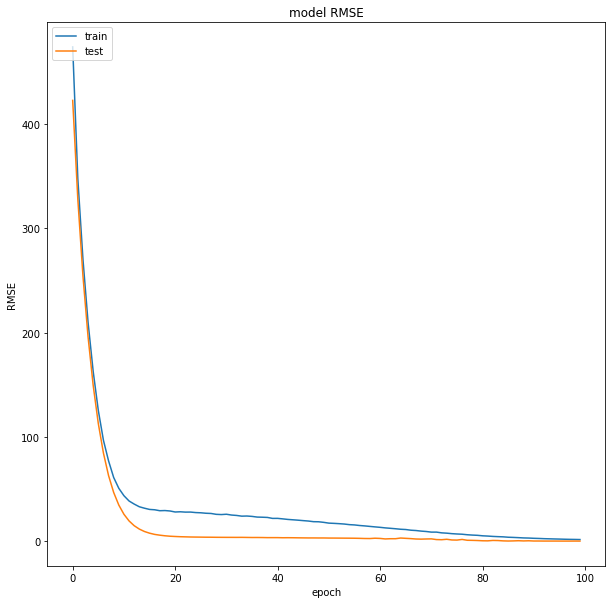

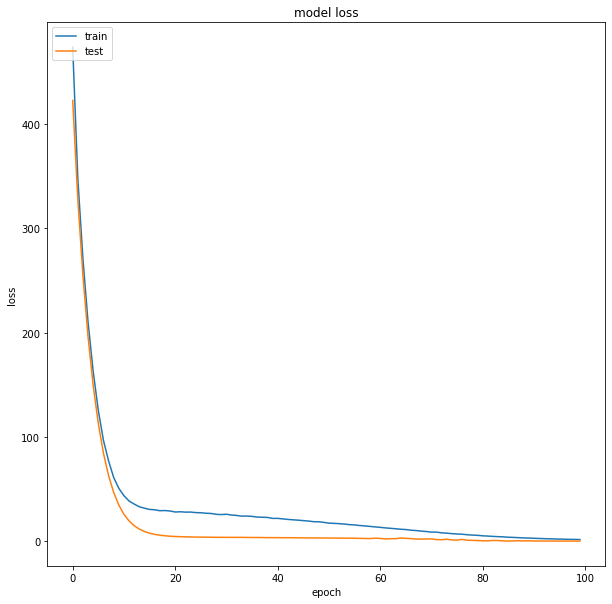

In [17]:
# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# fig_acc.savefig("LSTM_rmse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# fig_acc.savefig("LSTM_loss1.png")

In [18]:
#  Model Validation

val_arrays = []
val_labs = []

# create a list of sequences and labels, starting with a min of 2 readings
for end in range(seq_length+ph, len(test_df)-ph):
    #add short sequences until we reach the sequence length
    if end < seq_length:
        val_arrays.append(test_df[feat_cols][0:end].to_numpy())
        val_labs.append(test_df['Temperature'][end+ph])
    #add sequences of seq_length once we have enough data
    else:
        val_arrays.append(test_df[feat_cols][end-seq_length:end].to_numpy())
        val_labs.append(test_df['Temperature'][end+ph])
       
# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32)
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=object).astype(np.float32)

241/241 - 1s - loss: 0.1114 - mse: 0.1114 - 814ms/epoch - 3ms/step

MSE: 0.1114097386598587
241/241 [==============================] - 2s 5ms/step


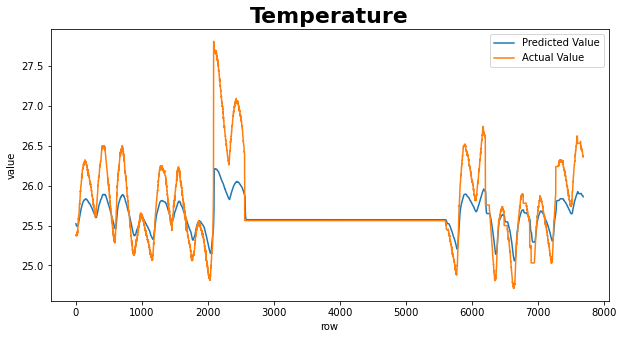

In [19]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('test_set.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the last 500 values
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Temperature', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
# fig_verify.savefig("model_regression_verify.png")
